In [1]:
from pytorch_lightning import Trainer
import active_catinous.FastGramDynamicMemoryBrainAge as braincatsmodel
from active_catinous.FastGramDynamicMemoryBrainAge import FastGramDynamicMemoryBrainAge
from datasets.BrainAgeDataset import BrainAgeDataset
from datasets.BrainAgeContinuous import BrainAgeContinuous

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns
import pickle
from py_jotools import mut, slurm, cache
import numpy as np
import gc

import hashlib
import dill
import active_catinous.utils as cutils

from sklearn.metrics import mean_absolute_error

from models.AgePredictor import EncoderRegressor
from models.unet3d import EncoderModelGenesis

%load_ext autoreload
%autoreload 


Bad key "text.kerning_factor" on line 4 in
/home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Base training

In [ ]:
schedule = False

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '240',
    'exclude': 'on3'}

hparams={'continous':False,
         'datasetfile': '/project/catinous/brainds_split_val_test_balance.csv',
         'noncontinuous_train_splits': ['base_train'],
         'noncontinuous_steps': 2000,
         'root_dir': '',
         'batch_size': 2,
        'learning_rate':0.00001}

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

In [6]:
df = pd.read_csv('/project/catinous/brainds_split_val_test_balance.csv')
df = df.loc[df.Scanner.isin(['1.5T Philips', '3.0T Philips', '3.0T'])]
df.groupby(['split', 'Scanner']).count()

Unnamed: 0    ID   Age  Image
split      Scanner                                    
base_train 1.5T Philips         201   201   201    201
test       1.5T Philips          31    31    31     31
           3.0T                 187   187   187    187
           3.0T Philips          18    18    18     18
train      1.5T Philips          52    52    52     52
           3.0T                1504  1504  1504   1504
           3.0T Philips         146   146   146    146
val        1.5T Philips          31    31    31     31
           3.0T                 187   187   187    187
           3.0T Philips          18    18    18     18

In [3]:
schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 5.0,
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'startbudget': 212,
        'len_perf_queue': 10
        }
    
sb=170
mm=64

hparams['startbudget'] = sb
hparams['memorymaximum'] = mm
hparams['run_postfix'] = 2

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous25756
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous25756.job
Submitted batch job 3035644



In [4]:
schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 5.0,
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 10
        }

sb=85
mm=64

hparams['startbudget'] = sb
hparams['memorymaximum'] = mm
hparams['run_postfix'] = 2

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous69988
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous69988.job
Submitted batch job 3035645



In [5]:
schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 5.0,
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 10
        }

sb=212
mm=64

hparams['startbudget'] = sb
hparams['memorymaximum'] = mm
hparams['run_postfix'] = 2

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous46153
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous46153.job
Submitted batch job 3035647



In [3]:
#experiments with startbudget of memory max 64 and 128
# 1/20 = 85
# 1/15 = 113 
# 1/10 = 170
# 1/8 = 212 with 0.00001 and 0.0001
# 1/5 = 340

schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 5,
         'transition_phase_after':0.7
        }

startbugdets = [85, 170, 212, 340]
memorymaximas = [128]

for i in range(3):
    for sb in startbugdets:
        for mm in memorymaximas:
            #if i==0 and ((sb==85 and mm==128) or (sb==85 and mm==64) or (sb==170 and mm==64) or (sb==170 and mm==128) or (sb==212 and mm==128)):
            #    pass
            #else:
                hparams['startbudget'] = sb
                hparams['memorymaximum'] = mm
                hparams['run_postfix'] = 1+i

                if schedule:
                    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
                else:
                    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous20626
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous20626.job
Submitted batch job 3057560

activecatinous59941
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous59941.job
Submitted batch job 3057561

activecatinous04837
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous04837.job
Submitted batch job 3057563

activecatinous05338
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous05338.job
Submitted batch job 3057564

activecatinous94819
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous94819.job
Submitted batch job 3057565

activecatinous79586
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/act

In [6]:
#experiments with startbudget of memory max 64 and 128
# 1/20 = 85
# 1/15 = 113 
# 1/10 = 170
# 1/8 = 212 with 0.00001 and 0.0001
# 1/5 = 340

schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 7.0, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }

hparams['startbudget'] = 212
hparams['memorymaximum'] = 128
hparams['run_postfix'] = 2

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous87416
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous87416.job
Submitted batch job 3057157



In [2]:
#experiments with startbudget of memory max 64 and 128
# 1/20 = 85
# 1/15 = 113 
# 1/10 = 170
# 1/8 = 212 with 0.00001 and 0.0001
# 1/5 = 340

schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 500,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 8.17, #performance for first domain after base training
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'len_perf_queue': 8,
         'transition_phase_after':0.7
        }

startbugdets = [85, 170, 212, 340]
memorymaximas = [64, 128]

sb=212
mm=128
i=0
#if i==0 and ((sb==85 and mm==128) or (sb==85 and mm==64) or (sb==170 and mm==64) or (sb==170 and mm==128) or (sb==212 and mm==128)):
#    pass
#else:
hparams['startbudget'] = sb
hparams['memorymaximum'] = mm
hparams['run_postfix'] = 1+i

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

activecatinous75198
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/activecatinous75198.job
Submitted batch job 3039450



In [3]:
df_wrong_scanner = df_cache.loc[df_cache.filepath=='1.5T Philips']
df_wrong_scanner = df_wrong_scanner.rename(columns={'filepath':'scanner', 'scanner':'filepath'})
df_cache.loc[df_cache.filepath=='1.5T Philips', 'filepath'] = np.NaN
df_cache = df_cache.dropna().reset_index()
df_cache = df_wrong_scanner.append(df_cache)

In [2]:
#experiments with startbudget of memory max 64 and 128
# 1/20 = 85
# 1/15 = 113
# 1/10 = 170
# 1/8 = 212
# 1/5 = 340

schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'naive_activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
         'naive_continuous_rate':15,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 32,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'transition_phase_after':0.7
        }


continuous_rate = [20, 10, 8, 5]
memorymaximas = [64, 128]

for i in range(3):
    for cr in continuous_rate:
        for mm in memorymaximas:
            hparams['naive_continuous_rate'] = cr
            hparams['memorymaximum'] = mm
            hparams['run_postfix'] = i+1
            if schedule:
                slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
            else:
                model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

naive_activecatinous18009
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous18009.job
Submitted batch job 3045284

naive_activecatinous80834
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous80834.job
Submitted batch job 3045285

naive_activecatinous29483
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous29483.job
Submitted batch job 3045286

naive_activecatinous76348
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous76348.job
Submitted batch job 3045288

naive_activecatinous58108
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous58108.job
Submitted batch job 3045289

naive_activecatinous42727
sshpass -f ~/.ssh/pass ssh cn1.cir.medu

In [2]:
#experiments with startbudget of memory max 64 and 128
# 1/20 = 85
# 1/15 = 113
# 1/10 = 170
# 1/8 = 212
# 1/5 = 340

schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'constraint': 'bigGPUmem',
    'jobname': 'naive_activecatinous',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '300'}

hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
         'naive_continuous_rate':15,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 32,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'transition_phase_after':0.7
        }

hparams['naive_continuous_rate'] = 10
hparams['memorymaximum'] = 64
hparams['run_postfix'] = 2
if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)
    
hparams['naive_continuous_rate'] = 10
hparams['memorymaximum'] = 64
hparams['run_postfix'] = 3
if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)
    
    
hparams['naive_continuous_rate'] = 8
hparams['memorymaximum'] = 128
hparams['run_postfix'] = 2
if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

naive_activecatinous74416
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous74416.job
Submitted batch job 3057555

naive_activecatinous79719
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous79719.job
Submitted batch job 3057556

naive_activecatinous50396
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/naive_activecatinous50396.job
Submitted batch job 3057557



In [6]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def test_hparams(hparams, dev='cuda'):
    device = torch.device(dev)
    test_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='1.5T Philips'), batch_size=4, num_workers=4)
    test_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='3.0T Philips'), batch_size=4, num_workers=4)
    test_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='test', res='3.0T'), batch_size=4, num_workers=4)
    
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams, train=False)
    
    target_15, output_15 = test_model(model, test_phil15, device)
    print('test phil 15', mean_absolute_error(target_15, output_15))
    target_30, output_30 = test_model(model, test_phil30, device)
    print('test phil 30', mean_absolute_error(target_30, output_30))
    target, output = test_model(model, test_30, device)
    print('test 30', mean_absolute_error(target, output))

In [3]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0
        }

In [4]:
hparams['startbudget'] = 340
test_hparams(hparams)

init
64
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_a4e882795d.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_a4e882795d.pt
test phil 15 7.734721
test phil 30 8.738034
test 30 9.165479


In [5]:
hparams['memorymaximum'] = 128
hparams['startbudget'] = 340
test_hparams(hparams)

init
128
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_10c966b4b1.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_10c966b4b1.pt
test phil 15 10.593702
test phil 30 9.637116
test 30 7.652421


In [4]:
hparams['startbudget'] = 212
test_hparams(hparams)

init
64
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_f2015c6759.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_f2015c6759.pt
test phil 15 7.535403
test phil 30 9.165476
test 30 8.642139


In [4]:
hparams['memorymaximum'] = 128
hparams['startbudget'] = 212
test_hparams(hparams)

init
128
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_976da7a5c0.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_976da7a5c0.pt
test phil 15 9.43274
test phil 30 9.942894
test 30 8.293361


In [4]:
hparams['startbudget'] = 212
hparams['learning_rate'] = 0.0001
test_hparams(hparams)

init
64
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_0852e230e6.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_0852e230e6.pt
test phil 15 8.0726185
test phil 30 8.782521
test 30 8.608504


In [4]:
hparams['startbudget'] = 170
test_hparams(hparams)

init
64
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_36e539216f.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_36e539216f.pt
test phil 15 8.222592
test phil 30 8.633889
test 30 9.691646


In [4]:
hparams['memorymaximum'] = 128
hparams['startbudget'] = 170
test_hparams(hparams)

init
128
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_6d9047026b.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_6d9047026b.pt
test phil 15 10.407262
test phil 30 9.433815
test 30 8.557557


In [4]:
hparams['startbudget'] = 85
test_hparams(hparams)

init
64
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_a9eba22ef7.pt
Read: /project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_a9eba22ef7.pt
No columns to parse from file
test phil 15 6.8602114
test phil 30 12.195896
test 30 12.864751


In [3]:
hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
        }

In [4]:
hparams['naive_continuous_rate'] = 5
test_hparams(hparams)

init
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_41354bd7b6.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_41354bd7b6.pt
test phil 15 8.129477
test phil 30 10.051588
test 30 7.8155146


In [4]:
hparams['naive_continuous_rate'] = 8
test_hparams(hparams)

init
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_518d2c6fdc.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_518d2c6fdc.pt
test phil 15 7.5707746
test phil 30 9.707224
test 30 8.643781


In [ ]:
hparams['naive_continuous_rate'] = 10
test_hparams(hparams)

In [4]:
hparams['naive_continuous_rate'] = 20
test_hparams(hparams)

init
/project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_5231941cc4.pt
Read: /project/catinous/active_catinous/trained_models/cont_naive_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_5231941cc4.pt
test phil 15 7.5746155
test phil 30 10.89379
test 30 8.107142


In [5]:
# lr 0.00001, cache 64, completion limit 6.5

target_15, output_15 = test_model(model, val_phil15, device)
print('val phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, val_phil30, device)
print('val phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, val_30, device)
print('val 30', mean_absolute_error(target, output))

phil 15 10.666701
phil 30 8.456664
30 8.365326


In [5]:
# lr 0.00001, cache 64, completion limit 6.5

target_15, output_15 = test_model(model, test_phil15, device)
print('test phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('test phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('test 30', mean_absolute_error(target, output))

test phil 15 7.6996946
test phil 30 9.11212
test 30 8.534444


In [6]:
# lr 0.00001, cache 64, completion limit 6.5

target_15, output_15 = test_model(model, test_phil15, device)
print('test phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('test phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('test 30', mean_absolute_error(target, output))

test phil 15 9.165473
test phil 30 9.36241
test 30 8.85728


In [6]:
# lr 0.00001, cache 64, completion limit 6.5

target_15, output_15 = test_model(model, test_phil15, device)
print('test phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('test phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('test 30', mean_absolute_error(target, output))

test phil 15 9.165473
test phil 30 9.36241
test 30 8.85728


In [5]:
# lr 0.000001, cache 64, completion limit 6.5

target_15, output_15 = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 10.048024
phil 30 14.706595
30 11.786385


In [ ]:
phil 15 6.451279
phil 30 11.190129
30 16.200583

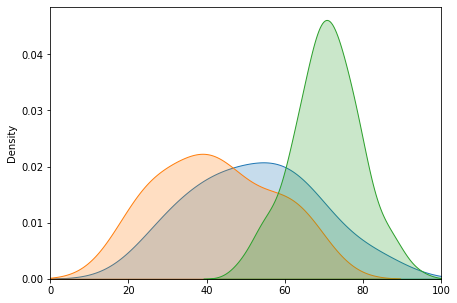

In [26]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.set_xlim([0, 100])
sns.kdeplot(target_15, shade=True, ax=ax, label='1.5T Philips')
sns.kdeplot(target_30, shade=True, ax=ax, label='3.0T Philips')
sns.kdeplot(target, shade=True, ax=ax, label='3.0T Siemens')

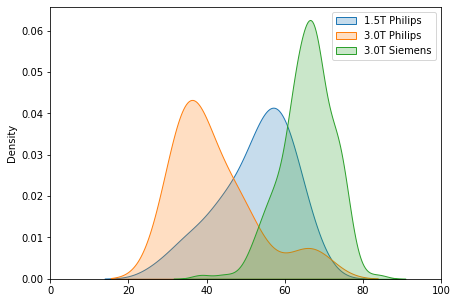

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.set_xlim([0, 100])
sns.kdeplot(output_15, shade=True, ax=ax, label='1.5T Philips')
sns.kdeplot(output_30, shade=True, ax=ax, label='3.0T Philips')
sns.kdeplot(output, shade=True, ax=ax, label='3.0T Siemens')
ax.legend()

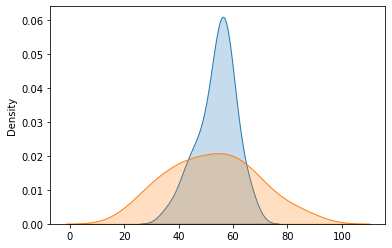

In [8]:
sns.kdeplot(output_15, shade=True)
sns.kdeplot(target_15, shade=True)

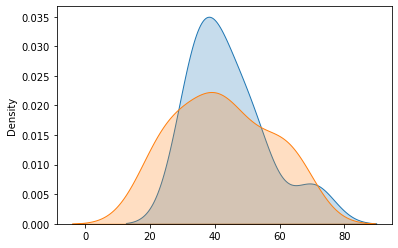

In [9]:
sns.kdeplot(output_30, shade=True)
sns.kdeplot(target_30, shade=True)

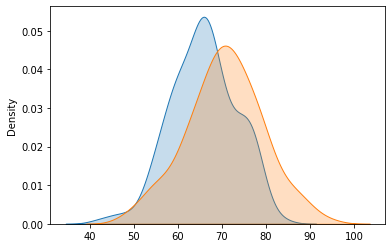

In [10]:
sns.kdeplot(output, shade=True)
sns.kdeplot(target, shade=True)

In [8]:
df = pd.read_csv('/project/catinous/brainds_split.csv')

2679

In [7]:
gram1 = np.array([-0.01316056, 0.01297002,  0.01034372, -0.01889127, -0.0077553, 0.01073803,
                      -0.02623499, 0.12702392, -0.02179161, -0.02619308, 0.07392235, 0.00097519,
                      0.01510646, 0.00574221, 0.04500553, 0.06350208, 0.01094581, -0.04030469,
                      0.05210259, 0.02890038, 0.03643065, 0.0147496, -0.02249765, 0.086908,
                      0.05209908,  0.01729487,  0.0067578,0.05051985, -0.03565041,  0.06045241])

In [4]:
import torch.nn.functional as F

In [8]:
F.mse_loss(gram1, gram1, reduction='mean')

TypeError: 'int' object is not callable

# BASELINE! Joint training and every thing seperatly

In [3]:
schedule = False

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/active_catinous/',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'jobname': 'baseline_activecont',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '240'}

hparams={'continuous':False,
         'use_memory':False,
         'datasetfile': '/project/catinous/brainds_split.csv',
         'noncontinuous_train_splits': ['base_train', 'train'],
         'noncontinuous_steps': 2000,
         'root_dir': '',
         'batch_size': 2,
        'learning_rate': 0.0001,
        'scanner': '1.5T Philips'}

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

init
/project/catinous/active_catinous/trained_models/batch_brainds_split_base_train-train_1_8d80c641bf.pt
Read: /project/catinous/active_catinous/trained_models/batch_brainds_split_base_train-train_1_8d80c641bf.pt


In [ ]:
device = torch.device('cuda')
hparams={'continuous':False,
         #'use_memory':False,
         'datasetfile': '/project/catinous/brainds_split.csv',
         'noncontinous_train_splits': ['base_train', 'train'],
         'noncontinous_steps': 5000,
         'root_dir': '',
         'batch_size': 2,
        'learning_rate': 0.0001}


model = FastGramDynamicMemoryBrainAge(hparams, device)
model.load_state_dict(torch.load('/project/catinous/active_catinous/trained_models/batch_brainds_split_base_train-train_1_861e8c8d6f.pt'))
model.eval()
val_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='1.5T Philips'), batch_size=4, num_workers=4)
val_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='3.0T Philips'), batch_size=4, num_workers=4)
val_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='3.0T'), batch_size=4, num_workers=4)

In [6]:
target_15, output_15 = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 7.0311036
phil 30 9.228156
30 4.966187


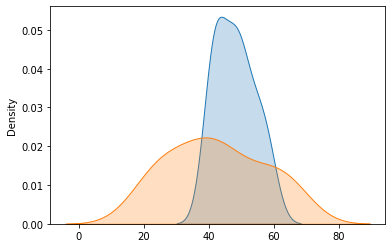

In [7]:
sns.kdeplot(output_30, shade=True)
sns.kdeplot(target_30, shade=True)

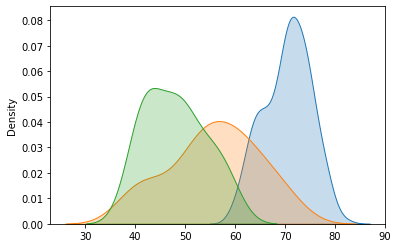

In [12]:
sns.kdeplot(output, shade=True)
sns.kdeplot(output_15, shade=True)
sns.kdeplot(output_30, shade=True)

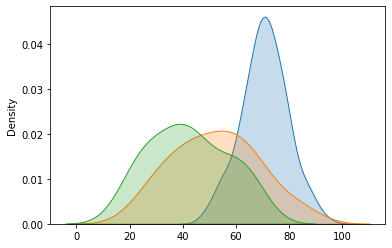

In [13]:
sns.kdeplot(target, shade=True)
sns.kdeplot(target_15, shade=True)
sns.kdeplot(target_30, shade=True)

In [5]:
device = torch.device('cuda')

hparams={'continuous':False,
         'datasetfile': '/project/catinous/brainds_split.csv',
         'noncontinuous_train_splits': ['base_train'],
         'noncontinuous_steps': 2000,
         'root_dir': '',
         'batch_size': 2,
        'learning_rate':0.00001}



model = FastGramDynamicMemoryBrainAge(hparams, device)
state_dict = torch.load('/project/catinous/active_catinous/trained_models/batch_brainds_split_base_train_1_af4af4fb90.pt')
new_state_dict = dict()
for key in state_dict.keys():
        new_state_dict[key.replace("model.", "")] = state_dict[key]
model.model.load_state_dict(new_state_dict)
model.eval()
pass

init
{}


In [6]:
target_15, output_15 = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 6.8602114
phil 30 12.195896
30 12.864751


In [8]:
val_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='1.5T Philips'), batch_size=4, num_workers=4)
val_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='3.0T Philips'), batch_size=4, num_workers=4)
val_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split.csv', split='val', res='3.0T'), batch_size=4, num_workers=4)

In [9]:
target_15, output_15 = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 8.173025
phil 30 12.502894
30 13.443603


In [6]:
#1.5T Philips
target_15, output_15 = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 7.106489
phil 30 11.239478
30 24.084946


In [6]:
#3.0T Philips
target_15, output_15 = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 21.801609
phil 30 6.7252007
30 9.425754


In [8]:
#3.0T
target_15, output_15 = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target_15, output_15))
target_30, output_30 = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target_30, output_30))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 15.2704
phil 30 22.398981
30 5.1909504


In [ ]:
phil 15 8.386715
phil 30 7.7561817
30 5.060874

In [11]:
df.groupby('split').count()

,Unnamed: 0,ID,Scanner,Age,Image
split,,,,,
base_train,200,200,200,200,200
test,267,267,267,267,267
train,1947,1947,1947,1947,1947
val,265,265,265,265,265


Unnamed: 0    ID   Age  Image
Scanner      split                                    
1.5T         test                23    23    23     23
             train              190   190   190    190
             val                 23    23    23     23
1.5T GE      test                 6     6     6      6
             train               56    56    56     56
             val                  6     6     6      6
1.5T Philips base_train         200   200   200    200
             test                32    32    32     32
             train               52    52    52     52
             val                 31    31    31     31
3.0T         test               187   187   187    187
             train             1504  1504  1504   1504
             val                187   187   187    187
3.0T Philips test                19    19    19     19
             train              145   145   145    145
             val                 18    18    18     18

In [7]:
d = {'bla':1, 'bluh':2}

In [10]:
'bladd' in d

False

# RESULTS

In [4]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not braincatsmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)
        else:            
            exp_name = cutils.get_expname(base_params[-1])

            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))
            
            df_temp = df_temp.loc[df_temp['val_mae_1.5T Philips']==df_temp['val_mae_1.5T Philips']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [8]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'startbudget': 212,
        }

res = res_data_for_params(hparams)

not cached
not cached
not cached
not cached


In [ ]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'startbudget': 212,
        }

#hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

startbugdets = [85, 113, 170, 212, 340]
memorymaximas = [32, 64, 128]

for sb in startbugdets:
    for mm in memorymaximas:
        hparams['startbudget'] = sb
        hparams['memorymaximum'] = mm
        res = res_data_for_params(hparams)
        if len(res)>0:
            fig, ax = plt.subplots(1,1, figsize=(10, 5))
            sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')
            ax.legend()
            ax.set_title(f'Memory: {mm}, Budget: {sb}')

not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached


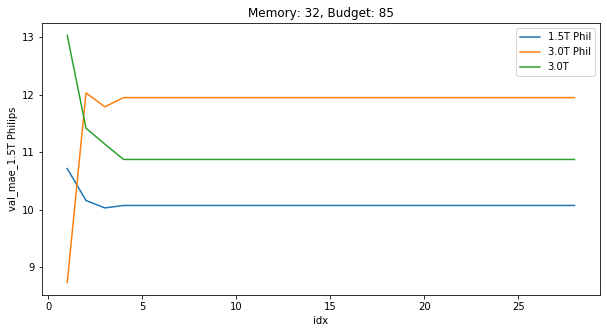

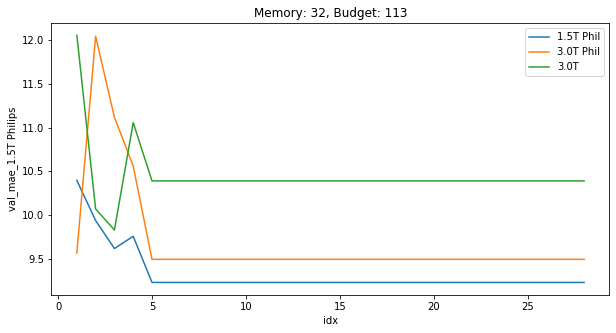

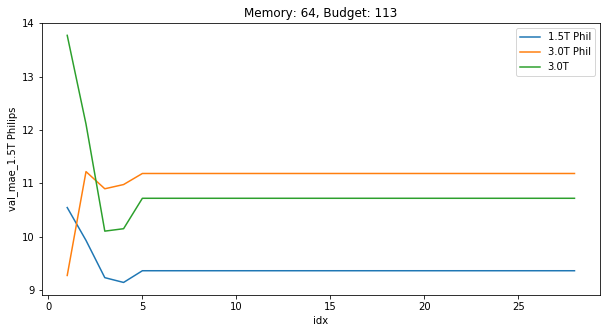

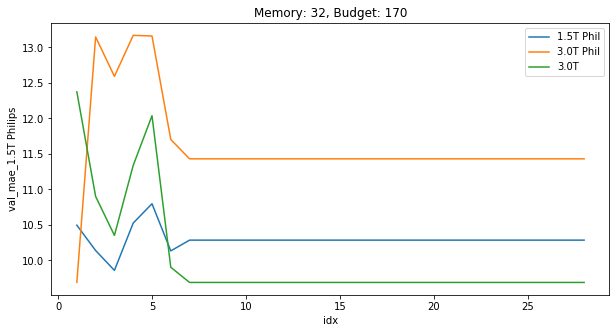

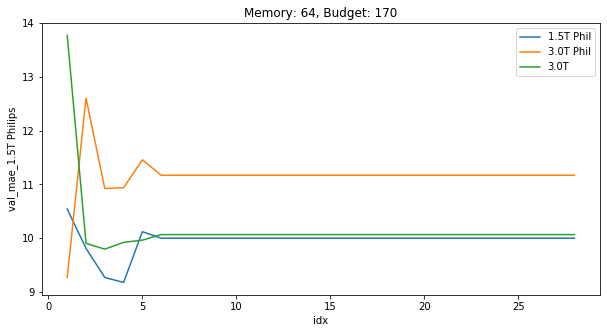

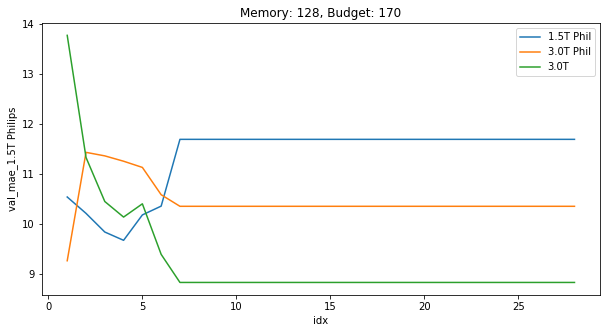

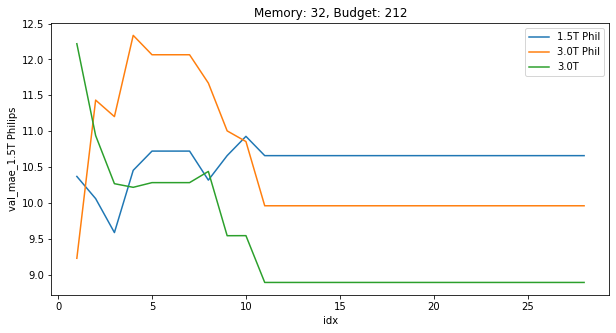

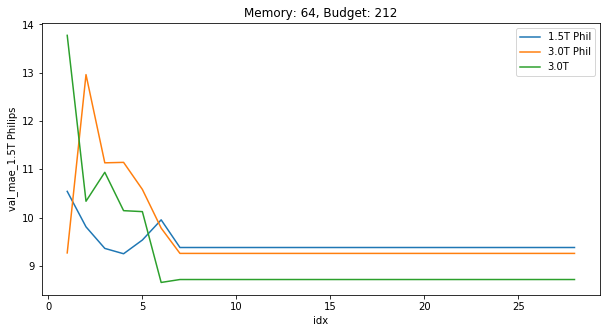

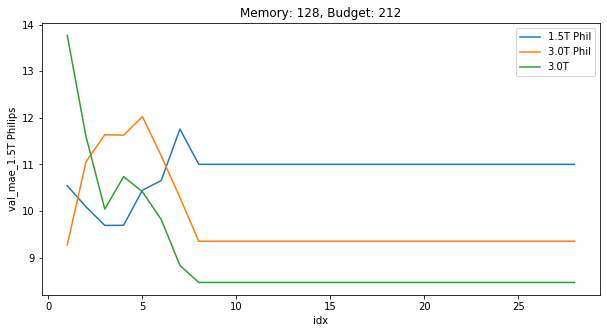

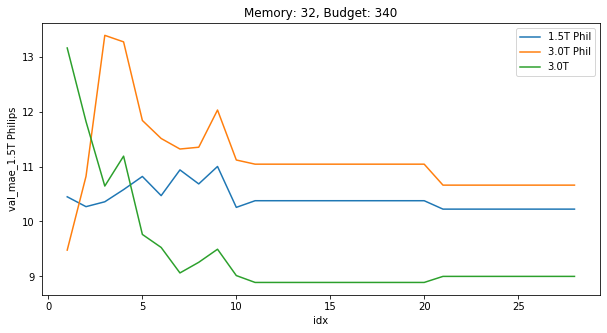

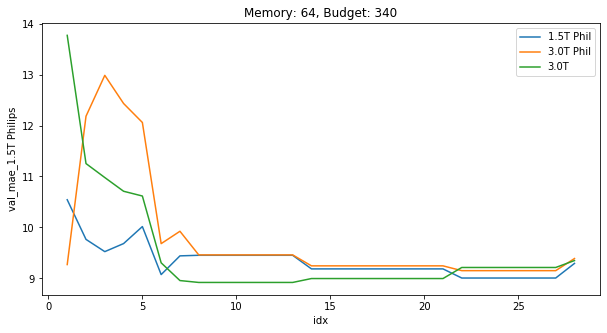

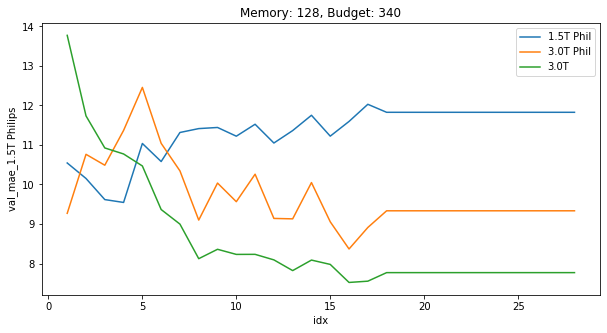

In [16]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'startbudget': 212,
        }

#hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

startbugdets = [85, 113, 170, 212, 340]
memorymaximas = [32, 64, 128]

for sb in startbugdets:
    for mm in memorymaximas:
        hparams['startbudget'] = sb
        hparams['memorymaximum'] = mm
        res = res_data_for_params(hparams)
        if len(res)>0:
            fig, ax = plt.subplots(1,1, figsize=(10, 5))
            sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')
            ax.legend()
            ax.set_title(f'Memory: {mm}, Budget: {sb}')

not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached
not cached


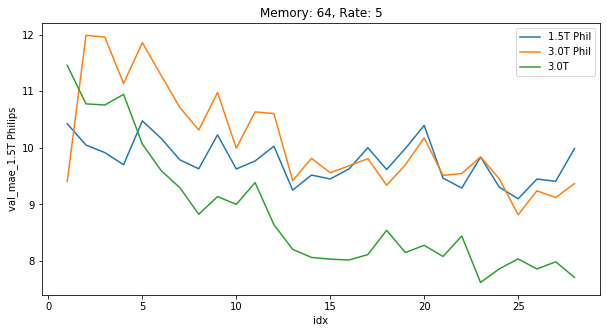

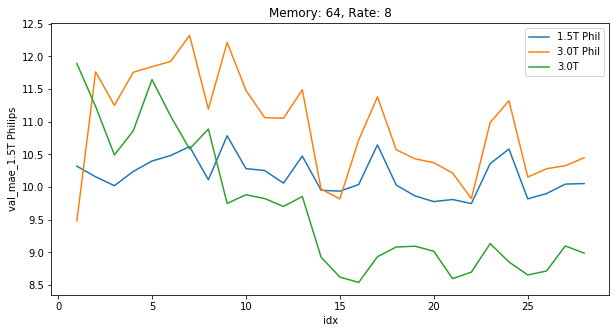

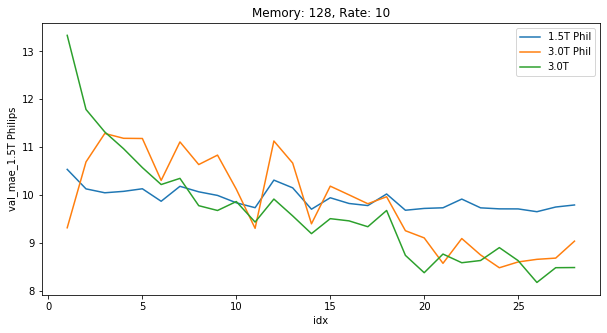

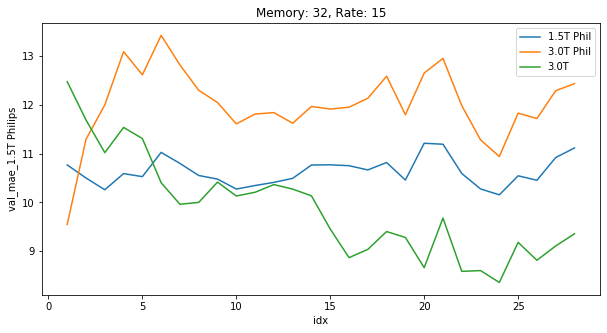

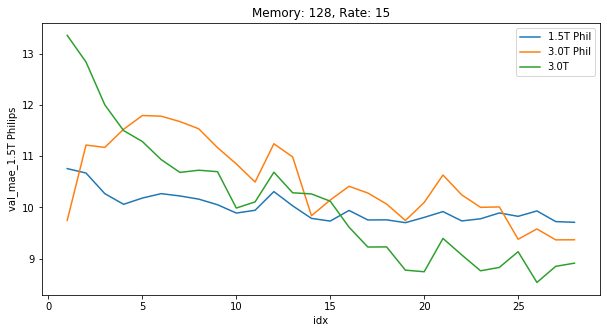

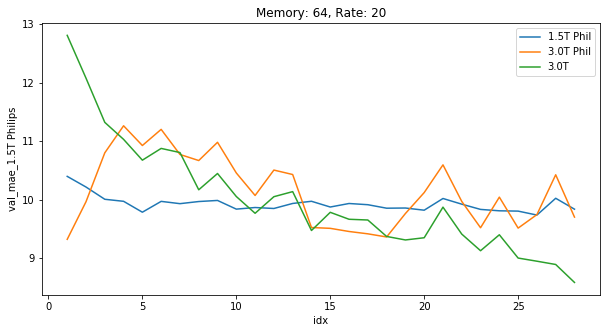

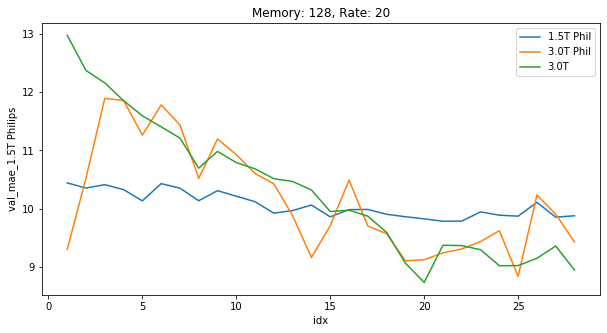

In [19]:
hparams={'continuous': True,
         'use_memory': True,
         'naive_continuous': True,
         'naive_continuous_rate':15,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 30,
        'run_postfix': 1,
        'memorymaximum': 32,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 4,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
        }

cont_rate = [5, 8, 10, 15, 20]
memorymaximas = [32, 64, 128]

for cr in cont_rate:
    for mm in memorymaximas:
        hparams['naive_continuous_rate'] = cr
        hparams['memorymaximum'] = mm
        res = res_data_for_params(hparams)
        if len(res)>0:
            fig, ax = plt.subplots(1,1, figsize=(10, 5))
            sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None,ax=ax, label='1.5T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None, ax=ax, label='3.0T Phil')
            sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None,ax=ax, label='3.0T')
            ax.legend()
            ax.set_title(f'Memory: {mm}, Rate: {cr}')

In [6]:
hparams={'continuous': True,
         'use_memory':True,
        'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_af4af4fb90.pt',
        'val_check_interval': 10,
        'run_postfix': 1,
        'memorymaximum': 64,
        'force_misclassified':True,
        'completion_limit': 6.5,
        'batch_size': 2,
        'training_batch_size': 8,
         'learning_rate': 0.00001,
         'random_cache': True,
         'gradient_clip_val': 0.5,
         'allowedlabelratio': 0,
         'startbudget': 212,
        }

hparams = cutils.default_params(FastGramDynamicMemoryBrainAge.get_default_hparams(), hparams)

startbugdets = [85, 113, 170, 212, 340]
memorymaximas = [32, 64, 128]

for sb in startbugdets:
    for mm in memorymaximas:
        hparams['startbudget'] = sb
        hparams['memorymaximum'] = mm
        
        if not braincatsmodel.is_cached(hparams):
            print(braincatsmodel.cached_path(hparams), mm, sb)

/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_61db6c8881.pt 128 212
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_b93441cad2.pt 32 340
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf08_1_977e3f6ae7.pt 128 340


In [5]:
startbugdets = [85, 170, 212, 340]
memorymaximas = [64, 128]


for i in range(3):
    for sb in startbugdets:
        for mm in memorymaximas:
            hparams['startbudget'] = sb
            hparams['memorymaximum'] = mm
            hparams['run_postfix'] = i+1
            print(braincatsmodel.cached_path(hparams), mm, sb, i+1)

/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_edb1754897.pt 64 85 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_13eca4679a.pt 128 85 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_d605aaf8ab.pt 64 170 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_83dd0cce97.pt 128 170 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_7e40551f08.pt 64 212 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_3d694f760f.pt 128 212 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memory_tf07_1_e499a13401.pt 64 340 1
/project/catinous/active_catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_memo